In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes, tree
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import roc_curve, auc

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./data/model_ready.csv')

1    0.592381
0    0.407619
Name: success, dtype: float64


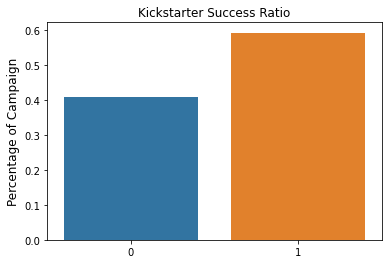

In [4]:
target = df.success.value_counts(normalize=True) 
print(target)
sns.barplot(target.index, target.values)
plt.title('Kickstarter Success Ratio')
plt.ylabel('Percentage of Campaign', fontsize=12);

In [ ]:
# it's mildly imbalanced but not too bad

In [5]:
df.columns

Index(['success', 'goal_usd', 'country_US', 'cam_duration', 'prep_duration',
       'desc_length', 'spotlight_True', 'staff_pick_True',
       'main_category_Comics', 'main_category_Crafts', 'main_category_Dance',
       'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater'],
      dtype='object')

In [6]:
df.drop(['spotlight_True'], axis=1, inplace=True)

In [7]:
df.rename(columns={'main_category_Comics': 'Comics',
                   'main_category_Crafts': 'Crafts', 
                   'main_category_Dance': 'Dance', 
                   'main_category_Design': 'Design',
                   'main_category_Fashion': 'Fashion', 
                   'main_category_Film & Video': 'Film_Video',
                   'main_category_Food': 'Food', 
                   'main_category_Games': 'Games', 
                   'main_category_Journalism': 'Journalism',
                   'main_category_Music': 'Music', 
                   'main_category_Photography': 'Photography',
                   'main_category_Publishing': 'Publishing', 
                   'main_category_Technology': 'Technology',
                   'main_category_Theater': 'Theater'}, inplace=True)
df.columns

Index(['success', 'goal_usd', 'country_US', 'cam_duration', 'prep_duration',
       'desc_length', 'staff_pick_True', 'Comics', 'Crafts', 'Dance', 'Design',
       'Fashion', 'Film_Video', 'Food', 'Games', 'Journalism', 'Music',
       'Photography', 'Publishing', 'Technology', 'Theater'],
      dtype='object')

In [8]:
X, y = df.drop(['success'], axis=1), df.success

X_mid, X_test, y_mid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_mid, y_mid, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

In [9]:
def make_confusion_matrix(model, threshold=0.6):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val_sc)[:,1] >=threshold)
    success_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(success_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['fail','success'],
           yticklabels=['fail','success']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

### KNN

In [10]:
# initiate model and calculate error metrics
knn = KNeighborsClassifier()
knn.fit(X_train_sc, y_train)
knn_pred = knn.predict(X_val_sc)
knn_confusion = confusion_matrix(y_val,knn_pred)

knn_ac = knn.score(X_val_sc, y_val)
knn_precision = precision_score(y_val, knn_pred)
knn_recall = recall_score(y_val, knn_pred)
knn_f1 = f1_score(y_val, knn_pred)

print(classification_report(y_val, knn_pred))

              precision    recall  f1-score   support

           0       0.63      0.57      0.60     12303
           1       0.72      0.77      0.74     17963

    accuracy                           0.69     30266
   macro avg       0.67      0.67      0.67     30266
weighted avg       0.68      0.69      0.68     30266



In [11]:
print('KNN validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (knn_ac, 
         knn_precision, 
         knn_recall,
         knn_f1)
     )
     

KNN validation metrics: 
 Accuracy: 0.6873 
 Precision: 0.7224 
 Recall: 0.7685 
 F1: 0.7447


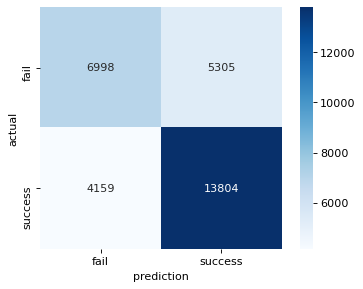

In [12]:
make_confusion_matrix(knn)

In [13]:
knn_y_score = knn.predict_proba(X_val_sc)[:,1]
knn_fpr, knn_tpr, knn_auc_thresholds = roc_curve(y_val, knn_y_score)
roc_auc_knn = auc(knn_fpr, knn_tpr)
print(roc_auc_knn)

0.7286900042696615


### Logistic Regression

In [14]:
lr = LogisticRegression()
lr.fit(X_train_sc, y_train)
lr_pred = lr.predict(X_val_sc)

lr_ac = lr.score(X_val_sc, y_val)
lr_precision = precision_score(y_val, lr_pred)
lr_recall = recall_score(y_val, lr_pred)
lr_f1 = f1_score(y_val, lr_pred)

print(classification_report(y_val, lr_pred))

              precision    recall  f1-score   support

           0       0.69      0.53      0.60     12303
           1       0.72      0.84      0.77     17963

    accuracy                           0.71     30266
   macro avg       0.70      0.68      0.69     30266
weighted avg       0.71      0.71      0.70     30266



In [15]:
print('Logistic Regression validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (lr_ac, 
         lr_precision, 
         lr_recall,
         lr_f1)
     )

Logistic Regression validation metrics: 
 Accuracy: 0.7112 
 Precision: 0.7218 
 Recall: 0.8354 
 F1: 0.7745


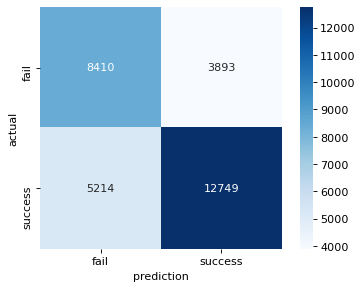

In [16]:
make_confusion_matrix(lr)

In [17]:
lr_y_score = lr.predict_proba(X_val_sc)[:,1]
lr_fpr, lr_tpr, lr_auc_thresholds = roc_curve(y_val, lr_y_score)
roc_auc_lr = auc(lr_fpr, lr_tpr)
print(roc_auc_lr)

0.7689321455965082


### Decision Tree

In [18]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_val)

dt_ac = dt.score(X_val, y_val)
dt_precision = precision_score(y_val, dt_pred)
dt_recall = recall_score(y_val, dt_pred)
dt_f1 = f1_score(y_val, dt_pred)

print(classification_report(y_val, dt_pred))

              precision    recall  f1-score   support

           0       0.58      0.61      0.60     12303
           1       0.72      0.70      0.71     17963

    accuracy                           0.66     30266
   macro avg       0.65      0.66      0.65     30266
weighted avg       0.67      0.66      0.67     30266



In [19]:
print('Decision Tree validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (dt_ac, 
         dt_precision, 
         dt_recall,
         dt_f1)
     )

Decision Tree validation metrics: 
 Accuracy: 0.6643 
 Precision: 0.7233 
 Recall: 0.7035 
 F1: 0.7132


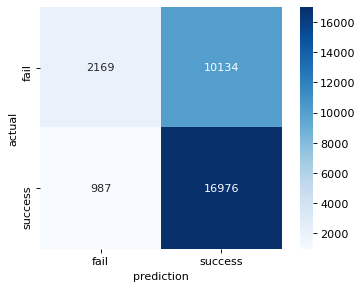

In [20]:
make_confusion_matrix(dt)

In [21]:
dt_y_score = dt.predict_proba(X_val)[:, 1]
dt_fpr, dt_tpr, auc_thresholds = roc_curve(y_val, dt_y_score)
roc_auc_dt = auc(dt_fpr, dt_tpr)
print(roc_auc_dt)

0.6555825561559978


### Random Forest

In [22]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)
rf_confusion = confusion_matrix(y_val, rf_pred)

rf_ac = rf.score(X_val, y_val)
rf_precision = precision_score(y_val, rf_pred)
rf_recall = recall_score(y_val, rf_pred)
rf_f1 = f1_score(y_val, rf_pred)

print(classification_report(y_val, rf_pred))

              precision    recall  f1-score   support

           0       0.69      0.62      0.65     12303
           1       0.76      0.81      0.78     17963

    accuracy                           0.73     30266
   macro avg       0.72      0.71      0.72     30266
weighted avg       0.73      0.73      0.73     30266



In [23]:
print('Random Forest validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (rf_ac, 
         rf_precision, 
         rf_recall,
         rf_f1)
     )

Random Forest validation metrics: 
 Accuracy: 0.7331 
 Precision: 0.7561 
 Recall: 0.8124 
 F1: 0.7833


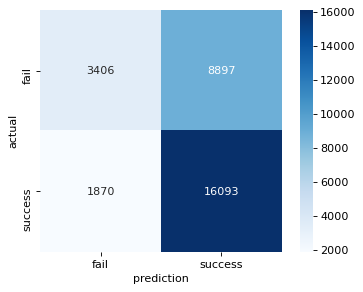

In [24]:
make_confusion_matrix(rf)

In [25]:
rf_y_score = rf.predict_proba(X_val)[:, 1]
rf_fpr, rf_tpr, auc_thresholds = roc_curve(y_val, rf_y_score)
roc_auc_rf = auc(rf_fpr, rf_tpr)
print(roc_auc_rf)

0.7934133702424948


### Naive Bayes

In [26]:
gnb = naive_bayes.GaussianNB()
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_val)
gnb_confusion = confusion_matrix(y_val, gnb_pred)

gnb_ac = gnb.score(X_val, y_val)
gnb_precision = precision_score(y_val, gnb_pred)
gnb_recall = recall_score(y_val, gnb_pred)
gnb_f1 = f1_score(y_val, gnb_pred)

print(classification_report(y_val, gnb_pred))

              precision    recall  f1-score   support

           0       0.84      0.08      0.14     12303
           1       0.61      0.99      0.75     17963

    accuracy                           0.62     30266
   macro avg       0.73      0.53      0.45     30266
weighted avg       0.70      0.62      0.50     30266



In [27]:
print('Gaussian validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (gnb_ac, 
         gnb_precision, 
         gnb_recall,
         gnb_f1)
     )

Gaussian validation metrics: 
 Accuracy: 0.6183 
 Precision: 0.6099 
 Recall: 0.9903 
 F1: 0.7549


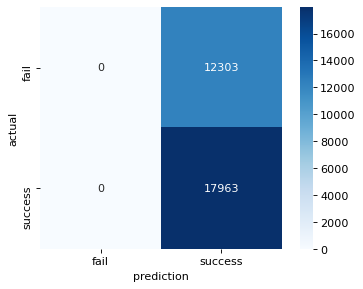

In [28]:
make_confusion_matrix(gnb)

In [29]:
gnb_y_score = gnb.predict_proba(X_val)[:, 1]
gnb_fpr, gnb_tpr, auc_thresholds = roc_curve(y_val, gnb_y_score)
roc_auc_gnb = auc(gnb_fpr, gnb_tpr)
print(roc_auc_gnb)

0.6384916208748999


In [30]:
bnb = naive_bayes.BernoulliNB()
bnb.fit(X_train, y_train)
bnb_pred = bnb.predict(X_val)
bnb_confusion = confusion_matrix(y_val, gnb_pred)

bnb_ac = gnb.score(X_val, y_val)
bnb_precision = precision_score(y_val, bnb_pred)
bnb_recall = recall_score(y_val, bnb_pred)
bnb_f1 = f1_score(y_val, bnb_pred)

print(classification_report(y_val, bnb_pred))

              precision    recall  f1-score   support

           0       0.66      0.52      0.58     12303
           1       0.71      0.81      0.76     17963

    accuracy                           0.70     30266
   macro avg       0.69      0.67      0.67     30266
weighted avg       0.69      0.70      0.69     30266



In [31]:
print('Bernoulli validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (bnb_ac, 
         bnb_precision, 
         bnb_recall,
         bnb_f1)
     )

Bernoulli validation metrics: 
 Accuracy: 0.6183 
 Precision: 0.7129 
 Recall: 0.8143 
 F1: 0.7603


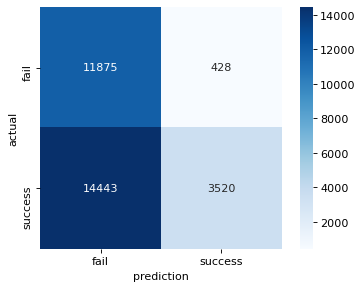

In [32]:
make_confusion_matrix(bnb)

In [33]:
bnb_y_score = bnb.predict_proba(X_val)[:, 1]
bnb_fpr, bnb_tpr, auc_thresholds = roc_curve(y_val, bnb_y_score)
roc_auc_bnb = auc(bnb_fpr, bnb_tpr)
print(roc_auc_bnb)

0.7370205205061102


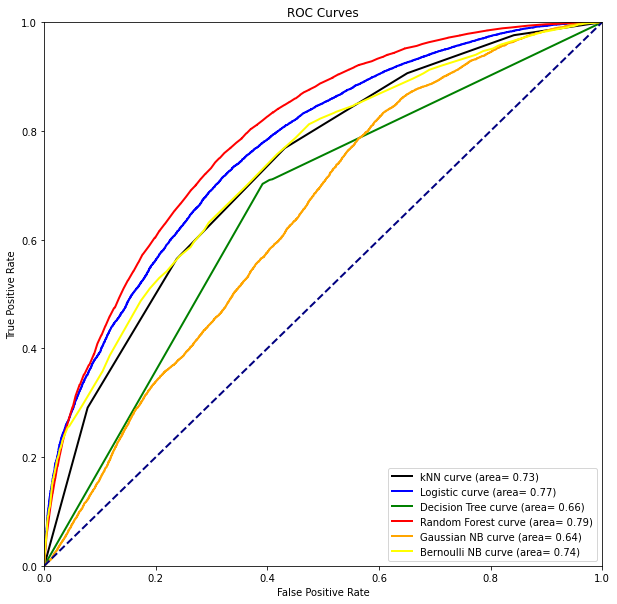

In [34]:
# all models ROC Curve comparison
plt.figure(figsize=(10,10))
lw = 2
plt.plot(knn_fpr, knn_tpr, color='black', lw=lw, 
         label='kNN curve (area= %0.2f)' %roc_auc_knn)
plt.plot(lr_fpr, lr_tpr, color='blue', lw=lw, 
         label='Logistic curve (area= %0.2f)' %roc_auc_lr)
plt.plot(dt_fpr, dt_tpr, color='green', lw=lw, 
         label='Decision Tree curve (area= %0.2f)' %roc_auc_dt)
plt.plot(rf_fpr, rf_tpr, color='red', lw=lw, 
         label='Random Forest curve (area= %0.2f)' %roc_auc_rf)
plt.plot(gnb_fpr, gnb_tpr, color='orange', lw=lw, 
         label='Gaussian NB curve (area= %0.2f)' %roc_auc_gnb)
plt.plot(bnb_fpr, bnb_tpr, color='yellow', lw=lw, 
         label='Bernoulli NB curve (area= %0.2f)' %roc_auc_bnb)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right');

In [ ]:
# appears Random Forest has the highest AUC score

In [36]:
xg = XGBClassifier()
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_val)

xg_ac = xg.score(X_val, y_val)
xg_precision = precision_score(y_val, xg_pred)
xg_recall = recall_score(y_val, xg_pred)
xg_f1 = f1_score(y_val, xg_pred)

xg_y_score = xg.predict_proba(X_val)[:, 1]
xg_fpr, xg_tpr, auc_thresholds = roc_curve(y_val, xg_y_score)
roc_auc_xg = auc(xg_fpr, xg_tpr)

print(classification_report(y_val, xg_pred))

[20:59:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.74      0.63      0.68     12303
           1       0.77      0.85      0.81     17963

    accuracy                           0.76     30266
   macro avg       0.75      0.74      0.74     30266
weighted avg       0.76      0.76      0.75     30266



In [37]:
print('XGBoost validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n ROC: %.4f' %
        (xg_ac, 
         xg_precision, 
         xg_recall,
         xg_f1,
         roc_auc_xg)
     )

XGBoost validation metrics: 
 Accuracy: 0.7574 
 Precision: 0.7689 
 Recall: 0.8451 
 F1: 0.8052 
 ROC: 0.8245


In [38]:
confusion_matrix(y_val, xg_pred)

array([[ 7741,  4562],
       [ 2782, 15181]])

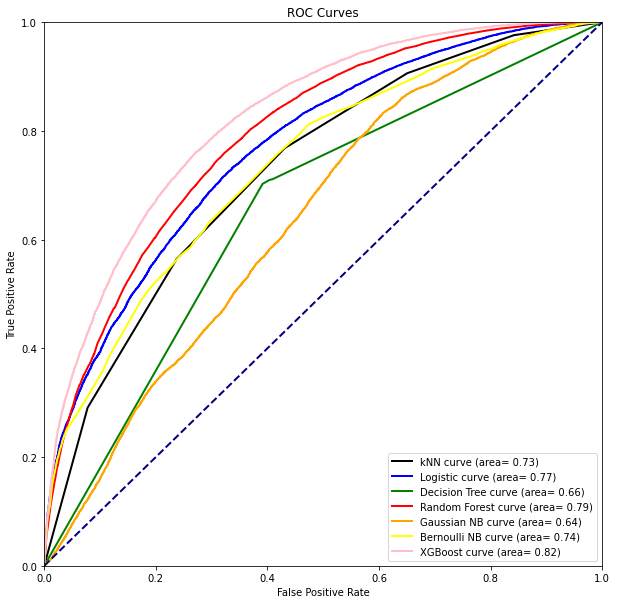

In [39]:
# all models ROC Curve comparison (+ XGBoost)
plt.figure(figsize=(10,10))
lw = 2
plt.plot(knn_fpr, knn_tpr, color='black', lw=lw, 
         label='kNN curve (area= %0.2f)' %roc_auc_knn)
plt.plot(lr_fpr, lr_tpr, color='blue', lw=lw, 
         label='Logistic curve (area= %0.2f)' %roc_auc_lr)
plt.plot(dt_fpr, dt_tpr, color='green', lw=lw, 
         label='Decision Tree curve (area= %0.2f)' %roc_auc_dt)
plt.plot(rf_fpr, rf_tpr, color='red', lw=lw, 
         label='Random Forest curve (area= %0.2f)' %roc_auc_rf)
plt.plot(gnb_fpr, gnb_tpr, color='orange', lw=lw, 
         label='Gaussian NB curve (area= %0.2f)' %roc_auc_gnb)
plt.plot(bnb_fpr, bnb_tpr, color='yellow', lw=lw, 
         label='Bernoulli NB curve (area= %0.2f)' %roc_auc_bnb)
plt.plot(xg_fpr, xg_tpr, color='pink', lw=lw,
        label='XGBoost curve (area= %0.2f)' %roc_auc_xg)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right');

In [40]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X_mid)
X_test_sc = scaler.transform(X_test)

In [41]:
# test score on all models
##KNN
knn.fit(X_sc, y_mid)
knn_pred = knn.predict(X_test_sc)
knn_confusion = confusion_matrix(y_test,knn_pred)

knn_ac = knn.score(X_test_sc, y_test)
knn_precision = precision_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)

knn_y_score = knn.predict_proba(X_test_sc)[:,1]
knn_fpr, knn_tpr, knn_auc_thresholds = roc_curve(y_test, knn_y_score)
roc_auc_knn = auc(knn_fpr, knn_tpr)

##Logistic Regression
lr.fit(X_sc, y_mid)
lr_pred = lr.predict(X_test_sc)

lr_ac = lr.score(X_test_sc, y_test)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)

lr_y_score = lr.predict_proba(X_test_sc)[:,1]
lr_fpr, lr_tpr, lr_auc_thresholds = roc_curve(y_test, lr_y_score)
roc_auc_lr = auc(lr_fpr, lr_tpr)

##Decision Tree
dt.fit(X_mid, y_mid)
dt_pred = dt.predict(X_test)

dt_ac = dt.score(X_test, y_test)
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)

dt_y_score = dt.predict_proba(X_test)[:, 1]
dt_fpr, dt_tpr, auc_thresholds = roc_curve(y_test, dt_y_score)
roc_auc_dt = auc(dt_fpr, dt_tpr)

##Random Forest
rf.fit(X_mid, y_mid)
rf_pred = rf.predict(X_test)
rf_confusion = confusion_matrix(y_test, rf_pred)

rf_ac = rf.score(X_test, y_test)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

rf_y_score = rf.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, auc_thresholds = roc_curve(y_test, rf_y_score)
roc_auc_rf = auc(rf_fpr, rf_tpr)

##Gaussian NB
gnb.fit(X_mid, y_mid)
gnb_pred = gnb.predict(X_test)
gnb_confusion = confusion_matrix(y_test, gnb_pred)

gnb_ac = gnb.score(X_test, y_test)
gnb_precision = precision_score(y_test, gnb_pred)
gnb_recall = recall_score(y_test, gnb_pred)
gnb_f1 = f1_score(y_test, gnb_pred)

gnb_y_score = gnb.predict_proba(X_test)[:, 1]
gnb_fpr, gnb_tpr, auc_thresholds = roc_curve(y_test, gnb_y_score)
roc_auc_gnb = auc(gnb_fpr, gnb_tpr)

##Bernoulli NB
bnb.fit(X_mid, y_mid)
bnb_pred = bnb.predict(X_test)
bnb_confusion = confusion_matrix(y_test, bnb_pred)

bnb_ac = bnb.score(X_test, y_test)
bnb_precision = precision_score(y_test, bnb_pred)
bnb_recall = recall_score(y_test, bnb_pred)
bnb_f1 = f1_score(y_test, bnb_pred)

bnb_y_score = bnb.predict_proba(X_test)[:, 1]
bnb_fpr, bnb_tpr, auc_thresholds = roc_curve(y_test, bnb_y_score)
roc_auc_bnb = auc(bnb_fpr, bnb_tpr)

##XGBoost
xg.fit(X_mid, y_mid)
xg_pred = xg.predict(X_test)

xg_ac = xg.score(X_test, y_test)
xg_precision = precision_score(y_test, xg_pred)
xg_recall = recall_score(y_test, xg_pred)
xg_f1 = f1_score(y_test, xg_pred)

xg_y_score = xg.predict_proba(X_test)[:, 1]
xg_fpr, xg_tpr, auc_thresholds = roc_curve(y_test, xg_y_score)
roc_auc_xg = auc(xg_fpr, xg_tpr)

[21:23:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [42]:
col_list = ['Model_type','accuracy', 'precision', 'recall', 'f1', 'roc']
knn_dict = dict(zip(col_list, ['KNN', knn_ac, knn_precision, knn_recall, knn_f1, roc_auc_knn]))
lr_dict = dict(zip(col_list, ['Logistic', lr_ac, lr_precision, lr_recall, lr_f1, roc_auc_lr]))
dt_dict = dict(zip(col_list, ['Decision Tree', dt_ac, dt_precision, dt_recall, dt_f1, roc_auc_dt]))
rf_dict = dict(zip(col_list, ['Random Forest', rf_ac, rf_precision, rf_recall, rf_f1, roc_auc_rf]))
gnb_dict = dict(zip(col_list, ['Gaussian', gnb_ac, gnb_precision, gnb_recall, gnb_f1, roc_auc_gnb]))
bnb_dict = dict(zip(col_list, ['Bernoulli', bnb_ac, bnb_precision, bnb_recall, bnb_f1, roc_auc_bnb]))
xg_dict = dict(zip(col_list, ['XGBoost', xg_ac, xg_precision, xg_recall, xg_f1, roc_auc_xg]))

score_df = pd.DataFrame([knn_dict, lr_dict, dt_dict, rf_dict, gnb_dict, bnb_dict, xg_dict])
score_df

,Model_type,accuracy,precision,recall,f1,roc
0,KNN,0.684878,0.719178,0.768133,0.742850,0.724056
1,Logistic,0.708799,0.717054,0.840039,0.773690,0.767329
2,Decision Tree,0.660693,0.719395,0.700687,0.709918,0.652432
3,Random Forest,0.724526,0.749729,0.803238,0.775562,0.786305
4,Gaussian,0.617371,0.608783,0.991302,0.754319,0.638911
5,Bernoulli,0.686676,0.706135,0.807119,0.753258,0.728532
6,XGBoost,0.750879,0.762051,0.842716,0.800356,0.816843


In [43]:
score_df.to_csv('score.csv')